#Remote Sensing Image Classification


##Import libraries



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from keras.preprocessing import image
import shutil

from keras import models
from keras import layers
from keras import optimizers

## Import Dataset

Como nuestro dataset se encuentra en un drive grupal, utilizamos la siguiente librería:

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
shutil.copy2('/content/gdrive/MyDrive/NWPU-RESISC45.rar', '/content') 

'/content/NWPU-RESISC45.rar'

In [ ]:
shutil.copy2('/content/gdrive/MyDrive/model_VGG16_FineTune.h5','/content')

'/content/model_VGG16_FineTune.h5'

In [ ]:
shutil.copy2('/content/gdrive/MyDrive/model_VGG16_NewFineTune.h5','/content') 

'/content/model_VGG16_NewFineTune.h5'

In [ ]:
!unrar x NWPU-RESISC45.rar

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Extracting  NWPU-RESISC45/snowberg/snowberg_609.jpg                       83%  OK 
Extracting  NWPU-RESISC45/snowberg/snowberg_610.jpg                       83%  OK 
Extracting  NWPU-RESISC45/snowberg/snowberg_611.jpg                       83%  OK 
Extracting  NWPU-RESISC45/snowberg/snowberg_612.jpg                       83%  OK 
Extracting  NWPU-RESISC45/snowberg/snowberg_613.jpg                       83%  OK 
Extracting  NWPU-RESISC45/snowberg/snowberg_614.jpg                       83%  OK 
Extracting  NWPU-RESISC45/snowberg/snowberg_615.jpg                       83%  OK 
Extracting  NWPU-RESISC45/snowberg/snowberg_616.jpg                       83%  OK 
Extracting  NWPU-RESISC45/snowberg/snowberg_617.jpg                       83%  OK 
Extracting  NWPU-RESISC45/snowberg/snowberg_618.jpg                       83%  OK 
Extracting  N

In [ ]:
os.rename(r'NWPU-RESISC45',r'Dataset')

## Split the dataset in train, validation and test.

In [ ]:
root_dir = 'Dataset' # data root path
classes_dir = os.listdir(root_dir) #['good', 'bad'] #total labels

val_ratio = 0.1
test_ratio = 0.2
# Creating partitions of the data after shuffeling
for cls in classes_dir:
    
    os.makedirs(root_dir +'train/' + cls)
    os.makedirs(root_dir +'val/' + cls)
    os.makedirs(root_dir +'test/' + cls)
    
    src = root_dir +'/'+ cls # Folder to copy images from

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), 
                                                           int(len(allFileNames)* (1 - test_ratio))])
    
    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]
    
    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, root_dir +'train/' + cls)

    for name in val_FileNames:
        shutil.copy(name, root_dir +'val/' + cls)

    for name in test_FileNames:
        shutil.copy(name, root_dir +'test/' + cls)
    



VGG 16 with Keras, and imagenet weights.

In [ ]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3),
                  classifier_activation="softmax")

In [ ]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './cats_and_dogs_small'

train_dir = 'Datasettrain'
validation_dir = 'Datasetval'
test_dir = 'Datasettest'

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
  
    features = np.zeros(shape=(sample_count, 7,7, 512))    #4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = np.argmax(labels_batch)
        i += 1
        if i * batch_size >= sample_count:
            # Notar que este generador devuelve data indefinidamente en un loop,
            # debemos cortarlo con un "break" despues de que cada imagen haya sido vista una vez
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 22005 images belonging to 45 classes.
Found 3195 images belonging to 45 classes.
Found 6300 images belonging to 45 classes.


In [ ]:
train_features = np.reshape(train_features, (2000, 7 * 7 * 512)) #4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 7 * 7 * 512))
test_features = np.reshape(test_features, (1000, 7 * 7 * 512))

In [ ]:
train_features.shape

(2000, 25088)

In [ ]:
train_labels

array([ 3.,  3.,  3., ..., 27., 27., 27.])

## Feature Extraction

### First Model: Fully-connected without convolutional layer


In [ ]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(45, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 45)                11565     
Total params: 12,988,461
Trainable params: 12,988,461
Non-trainable params: 0
_________________________________________________________________


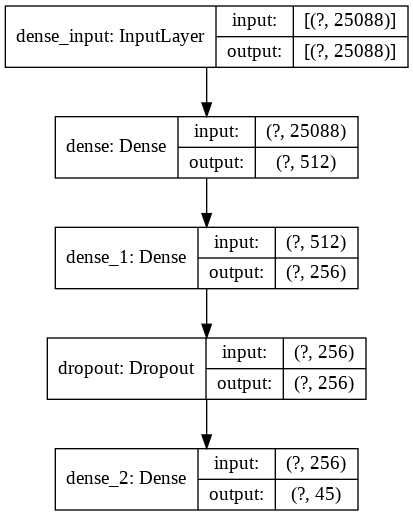

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

### Train first model


In [ ]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [ ]:
history = model.fit(train_features, train_labels,
                    epochs=120,
                    batch_size=15,
                    validation_data=(validation_features, validation_labels))

Epoch 1/120
134/134 [==============================] - 1s 11ms/step - loss: 3.7480 - acc: 0.0470 - val_loss: 4.0941 - val_acc: 0.0000e+00
Epoch 2/120
134/134 [==============================] - 1s 9ms/step - loss: 3.6009 - acc: 0.0630 - val_loss: 4.0510 - val_acc: 0.0260
Epoch 3/120
134/134 [==============================] - 1s 9ms/step - loss: 3.4649 - acc: 0.0955 - val_loss: 4.1429 - val_acc: 0.0190
Epoch 4/120
134/134 [==============================] - 1s 9ms/step - loss: 3.3262 - acc: 0.1340 - val_loss: 4.1727 - val_acc: 0.0200
Epoch 5/120
134/134 [==============================] - 1s 9ms/step - loss: 3.2000 - acc: 0.1745 - val_loss: 4.3458 - val_acc: 0.0270
Epoch 6/120
134/134 [==============================] - 1s 9ms/step - loss: 3.0340 - acc: 0.2205 - val_loss: 4.2528 - val_acc: 0.0180
Epoch 7/120
134/134 [==============================] - 1s 9ms/step - loss: 2.8742 - acc: 0.2840 - val_loss: 4.3621 - val_acc: 0.0070
Epoch 8/120
134/134 [==============================] - 1s 9ms/st

### Second Model

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(45, activation='softmax'))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 45)                11565     
Total params: 27,703,149
Trainable params: 27,703,149
Non-trainable params: 0
__________________________________________

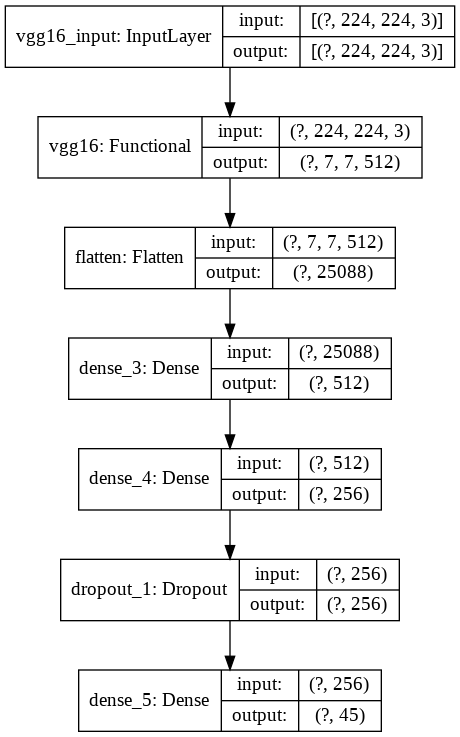

In [ ]:
model.summary()
plot_model(model, show_shapes=True)

In [ ]:
#Freeze network
conv_base.trainable = False

Data Augmentation with convolutional base VGG16

In [ ]:
# Define ImageDataGenerator
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # Directory target
        train_dir,
        # Rescale a 150x150
        target_size=(224, 224),
        batch_size=20,
        # Use binary_crossentropy
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=20,
        shuffle=False,
        class_mode='categorical')



Found 22005 images belonging to 45 classes.
Found 3195 images belonging to 45 classes.


Samples of transforming original images with ImageDataGenerator.

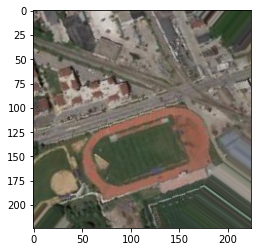

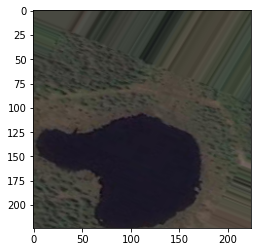

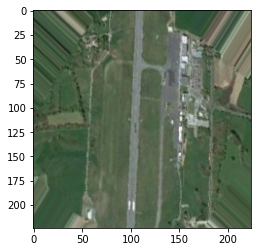

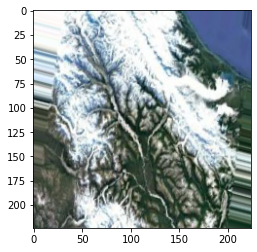

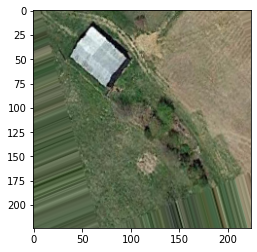

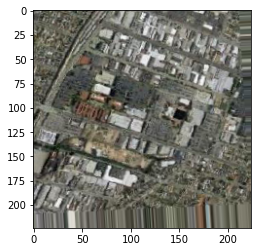

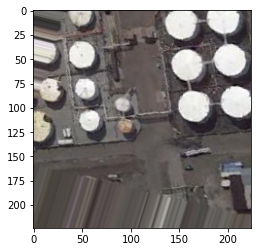

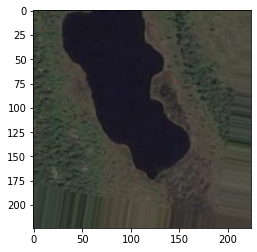

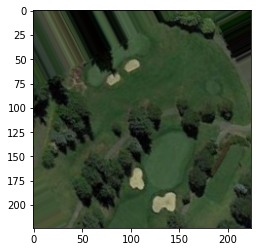

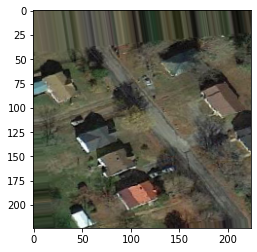

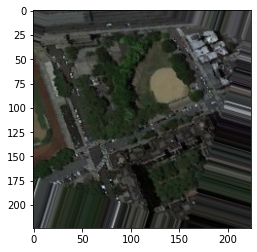

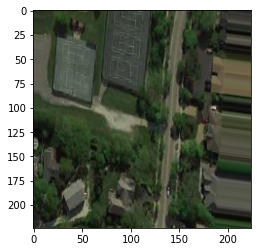

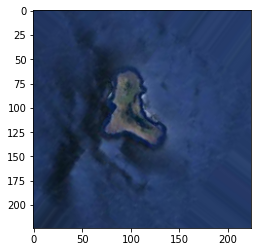

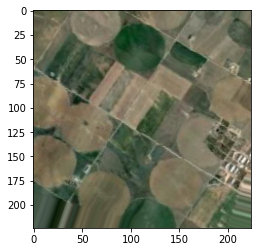

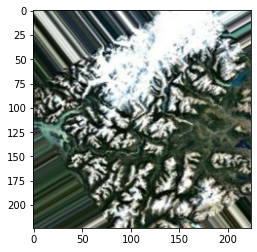

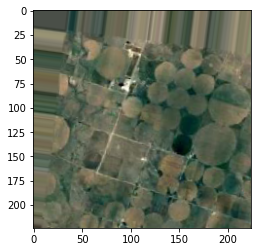

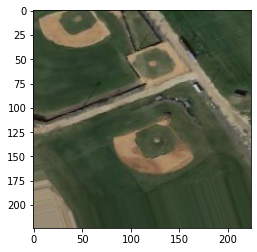

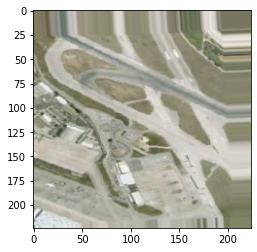

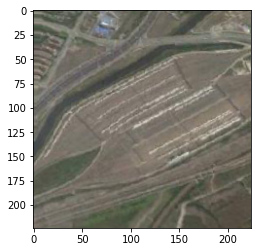

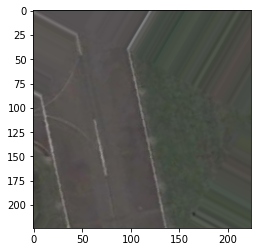

In [ ]:
sample_x,sample_y = next(train_generator)
for x,y in zip( sample_x,sample_y ):
    plt.imshow(x)
    
    plt.show()

### Compile and train Second Model

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
100/100 [==============================] - 32s 323ms/step - loss: 3.7178 - acc: 0.0750 - val_loss: 3.4877 - val_acc: 0.1790
Epoch 2/30
100/100 [==============================] - 32s 322ms/step - loss: 3.3582 - acc: 0.1690 - val_loss: 3.1586 - val_acc: 0.2340
Epoch 3/30
100/100 [==============================] - 32s 319ms/step - loss: 3.1090 - acc: 0.2230 - val_loss: 3.0149 - val_acc: 0.2220
Epoch 4/30
100/100 [==============================] - 33s 325ms/step - loss: 2.8862 - acc: 0.2795 - val_loss: 2.6638 - val_acc: 0.3260
Epoch 5/30
100/100 [==============================] - 32s 322ms/step - loss: 2.6972 - acc: 0.2990 - val_loss: 2.3519 - val_acc: 0.4320
Epoch 6/30
100/100 [==============================] - 32s 322ms/step - loss: 2.5286 - acc: 0.3390 - val_loss: 2.3178 - val_acc: 0.3990
Epoch 7/30
100/100 [==============================] - 32s 321ms/step - loss: 2.4274 - acc: 0.3665 - val_loss: 2.16

### Visualizing Lossand Accuracy - Train vs Validation

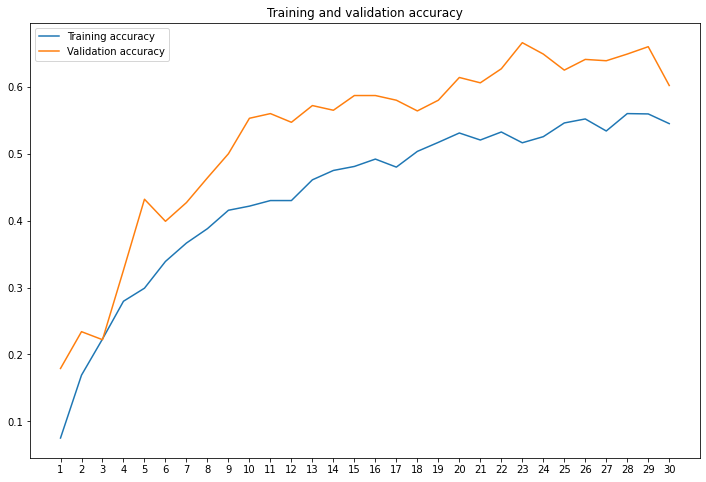

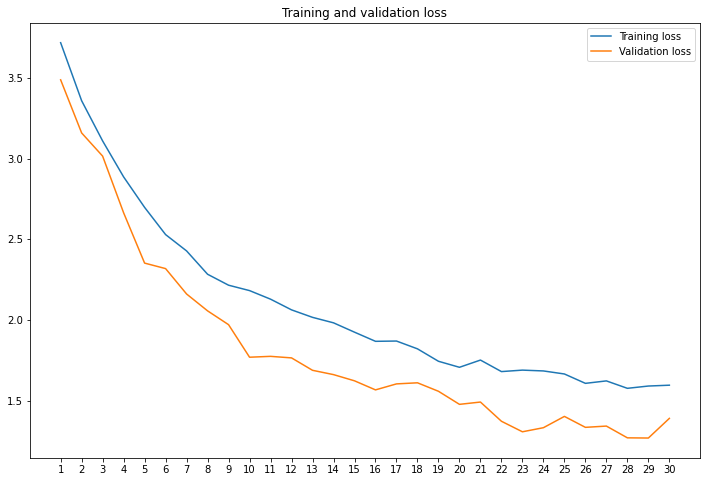

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xticks(ticks=epochs)
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(12,8))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xticks(ticks=epochs)
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Fine Tuning

### Split in train and validation with ImageDataGenerator

In [ ]:
# Definimos un generador de imágenes aumentadas
train_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # Directorio target
        train_dir,
        # Reescalamos a 150x150
        target_size=(224, 224),
        batch_size=20,
        # Usamos binary_crossentropy y etiquetas binarias
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=20,
        shuffle=False,
        class_mode='categorical')

Found 22005 images belonging to 45 classes.
Found 3195 images belonging to 45 classes.


Unfreezing the Layers to Fine-Tune setting trainable in True. Activate two convolutional blocks of VGG16 Network.

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if layer.name == 'block5_conv3':
        set_trainable = True
    layer.trainable = set_trainable  

In [ ]:
for layer in conv_base.layers:
  print(layer.name, layer.trainable)

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


### Instance the model


In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(45, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 45)                11565     
Total params: 27,703,149
Trainable params: 20,067,885
Non-trainable params: 7,635,264
__________________________________

Podemos observar la arquitectura del modelo instanciado.

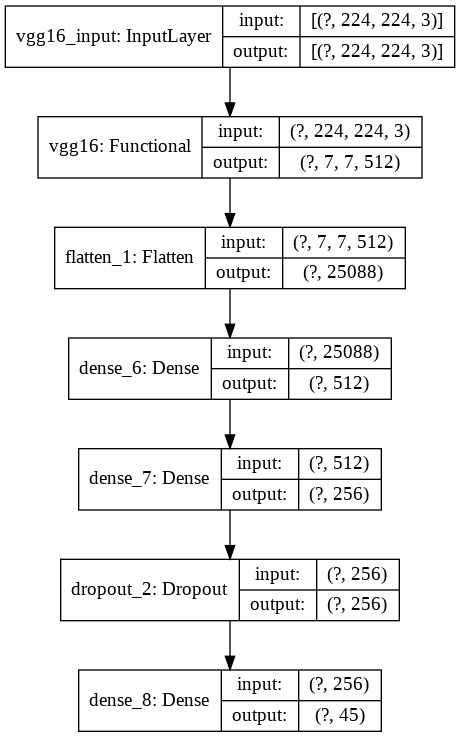

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

### Load saved weights. 

In [ ]:
shutil.copy2('/content/gdrive/MyDrive/model_VGG16.h5','/content')

'/content/model_VGG16.h5'

In [ ]:
# load weights into new model
model.load_weights("model_VGG16.h5")
print("Loaded model from disk")

Loaded model from disk


### Re-train the modelo  

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

### Saved the weights.

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model_VGG16.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_VGG16.h5")
print("Saved model to disk")

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical')

Found 6300 images belonging to 45 classes.


### Making Predictions

In [ ]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('Accuracy en test:', test_acc)

Instructions for updating:
Please use Model.evaluate, which supports generators.
Accuracy en test: 0.968999981880188


In [ ]:
classes_[np.argmax(test_generator[1][1][0])]

'island'

In [ ]:
classes_=sorted(os.listdir(test_dir))

In [ ]:
y_pred_proba, y_true = [], []
for j in range(32):
        (X, y) = next(test_generator)
        
        #y_pred_proba.append(model.predict(X))
        #y_true.append(y)
        a_=[classes_[np.argmax(y[i])] for i in range(len(X))]
        y_true=y_true+a_
        
        predcit_=model.predict(X)
        
        b_=[classes_[np.argmax(predcit_[i])] for i in range(len(X))]
        y_pred_proba=y_pred_proba+b_

### Confusion matrix

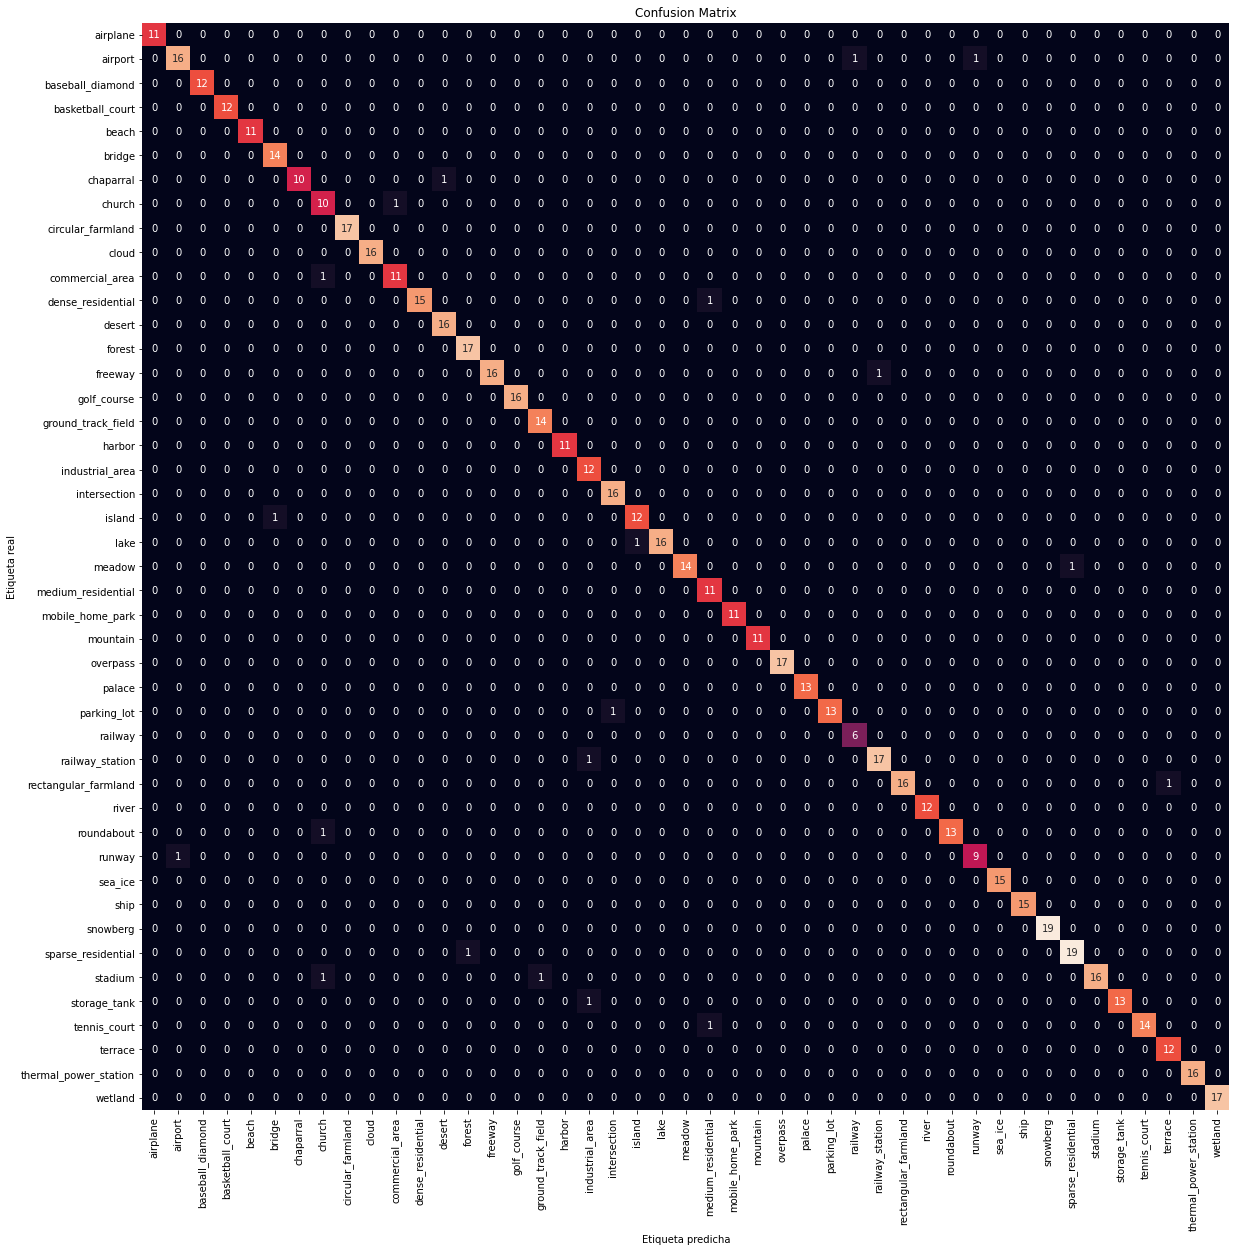


Classification Report:

                       precision    recall  f1-score   support

             airplane       1.00      1.00      1.00        11
              airport       0.94      0.89      0.91        18
     baseball_diamond       1.00      1.00      1.00        12
     basketball_court       1.00      1.00      1.00        12
                beach       1.00      1.00      1.00        11
               bridge       0.93      1.00      0.97        14
            chaparral       1.00      0.91      0.95        11
               church       0.77      0.91      0.83        11
    circular_farmland       1.00      1.00      1.00        17
                cloud       1.00      1.00      1.00        16
      commercial_area       0.92      0.92      0.92        12
    dense_residential       1.00      0.94      0.97        16
               desert       0.94      1.00      0.97        16
               forest       0.94      1.00      0.97        17
              freeway       1

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_proba)
tick_labels = classes_
plt.figure(figsize=(40,20))
sns.heatmap(conf_matrix, annot=True, fmt='.0f', square=True,
            xticklabels=tick_labels, yticklabels=tick_labels,
            cbar=False)
plt.ylabel('Etiqueta real')
plt.xlabel('Etiqueta predicha')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print('\nClassification Report:\n')
print(classification_report(y_true, y_pred_proba, target_names=classes_))

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt


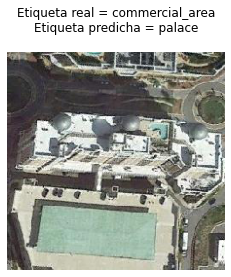

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

random_class = np.random.choice(os.listdir(test_dir))
random_image = np.random.choice(os.listdir('Datasettest/'+random_class))
random_image_file = 'Datasettest/'+random_class+'/'+random_image

# Leemos la imagen con tamaño (150, 150)
img = image.load_img(random_image_file, target_size=(224, 224))

# La pasamos a array con img_to_array()
# Le agregamos una dimensión con np.expand_dims() y normalizamos dividiendo por 255
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

prediction = model.predict(img_tensor)
class_pred=classes_[np.argmax(prediction)]

title = "Etiqueta real = {}\nEtiqueta predicha = {}\n".format(random_class, class_pred)
  
plt.title(title)
plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()

In [ ]:
random_image_file

'Datasettest/commercial_area/commercial_area_456.jpg'

In [ ]:
 prediction = model.predict(img_tensor)

In [ ]:
classes_[np.argmax(prediction)]

'palace'

### Visualizing accurate predictions

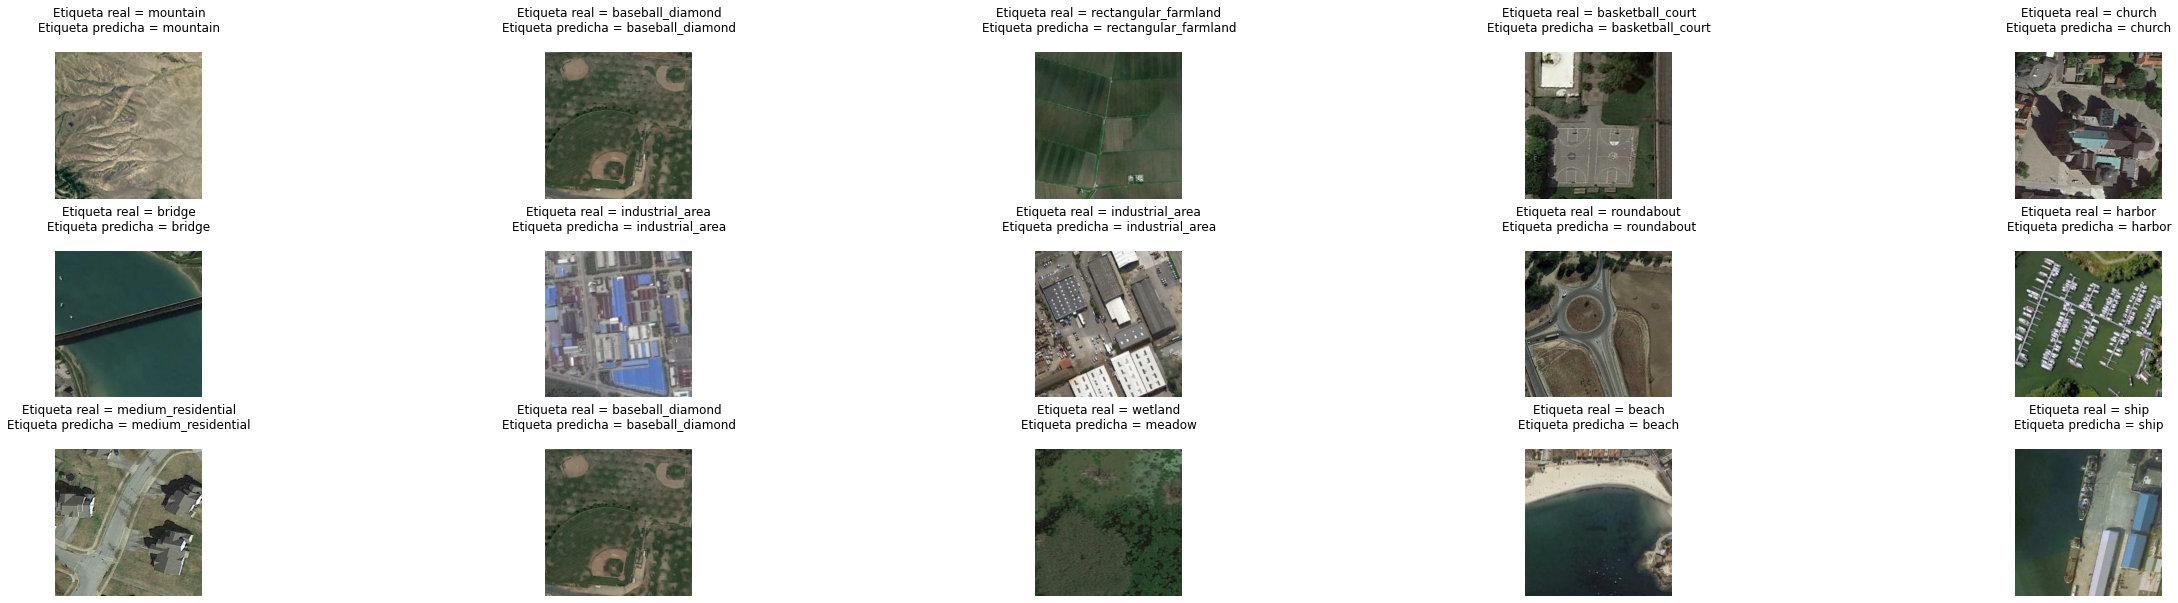

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
n = 15
fig, axes = plt.subplots(3, 5, figsize=(40,10))

plt.subplots_adjust(hspace = 0.35,wspace = 0.8)

class_pred=[]
random_class = np.random.choice(os.listdir(test_dir))
for i in range(n):
  
  random_class = np.random.choice(os.listdir(test_dir))
  random_image = np.random.choice(os.listdir('Datasettest/'+random_class))
  random_image_file = 'Datasettest/'+random_class+'/'+random_image

  # Leemos la imagen con tamaño (150, 150)
  img = image.load_img(random_image_file, target_size=(224, 224))


  # Le agregamos una dimensión con np.expand_dims() y normalizamos dividiendo por 255
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255.

  prediction = model.predict(img_tensor)
  class_pred.append(classes_[np.argmax(prediction)])

  title = "Etiqueta real = {}\nEtiqueta predicha = {}\n".format(random_class, class_pred[i])
    
  if i < 5 :
    j=i
    k=0
  if i > 4 and i < 10 :
    j=i-5
    k=1
  if i > 9 :
    j=i-10
    k=2
  
  axes[k,j].imshow(plt.imread(random_image_file))
  axes[k,j].set_title(title)
  axes[k,j].axis('off')

  


### Visualizing bad predictions

In [ ]:
class_pred=[]
random_class = np.random.choice(os.listdir(test_dir))
y_pred_proba, y_true = [], []
list_img=[]
files_badpred=[]
for i in range(len(classes_)):
  for j in range(len(os.listdir(test_dir+'/'+classes_[i]))):
    
    y_true.append(classes_[i])
    random_image = sorted(os.listdir('Datasettest/'+classes_[i]))[j]
    random_image_file = 'Datasettest/'+classes_[i]+'/'+random_image

    # Leemos la imagen con tamaño (150, 150)
    img = image.load_img(random_image_file, target_size=(224, 224))


    # Le agregamos una dimensión con np.expand_dims() y normalizamos dividiendo por 255
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.

    
    prediction = model.predict(img_tensor)
    pred_decode = classes_[np.argmax(prediction)]
    y_pred_proba.append(pred_decode)
    if pred_decode != classes_[i]:
      files_badpred.append(random_image_file)




In [ ]:
def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""

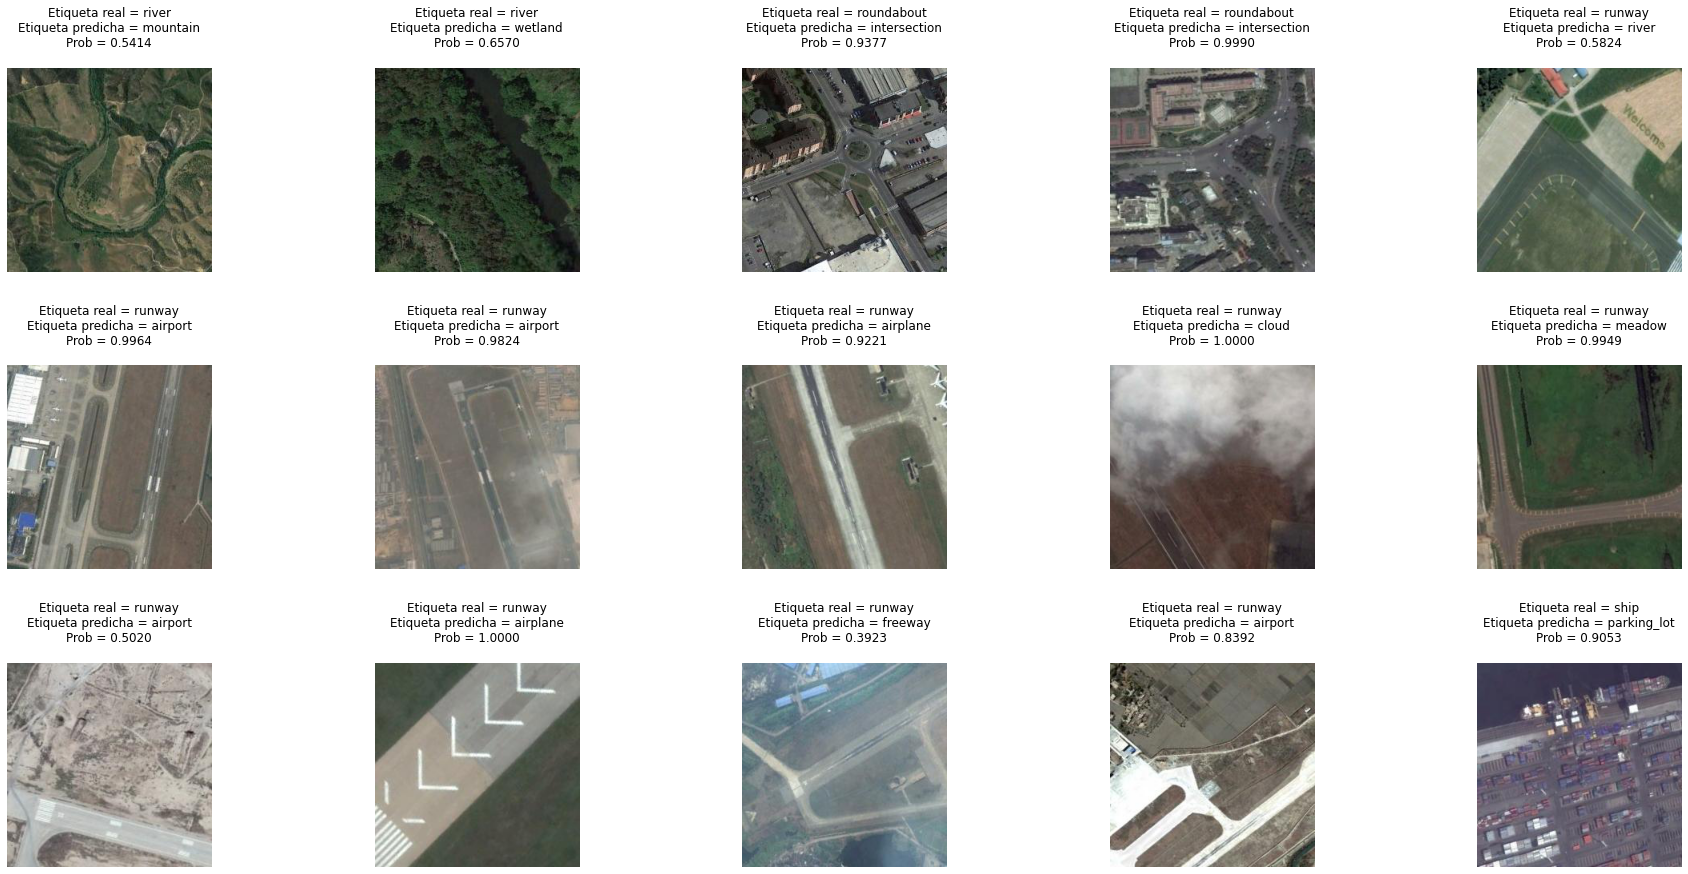

In [ ]:
n = 15
fig, axes = plt.subplots(3, 5, figsize=(30,15))

plt.subplots_adjust(hspace = 0.35,wspace = 0.8)


for i in range(n):
  
  random_image_file=files_badpred[i+135]
  random_class=find_between(random_image_file,'/','/')
  
  # Leemos la imagen con tamaño (150, 150)
  img = image.load_img(random_image_file, target_size=(224, 224))


  # Le agregamos una dimensión con np.expand_dims() y normalizamos dividiendo por 255
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255.

  prediction = model.predict(img_tensor)
  class_pred.append(classes_[np.argmax(prediction)])

  title = "Etiqueta real = {}\nEtiqueta predicha = {}\nProb = {:.4f}\n".format(random_class,classes_[np.argmax(prediction)],np.max(prediction))
    
  if i < 5 :
    j=i
    k=0
  if i > 4 and i < 10 :
    j=i-5
    k=1
  if i > 9 :
    j=i-10
    k=2
  
  axes[k,j].imshow(plt.imread(random_image_file))
  axes[k,j].set_title(title)
  axes[k,j].axis('off')

